In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import pandas as pd
from obspy.geodetics.base import gps2dist_azimuth,kilometer2degrees
from obspy.taup import TauPyModel
from obspy.signal.rotate import rotate_ne_rt
from matplotlib.ticker import MultipleLocator, AutoLocator
from obspy import read, read_inventory, Stream, Trace
from obspy.io.sac.sacpz import attach_paz
import numpy as np
import os, glob
import datetime
import warnings
warnings.filterwarnings("ignore")
model = TauPyModel(model="iasp91")
client = Client("IRIS")
plt.rcParams['font.sans-serif']='Times New Roman'

In [2]:
DATA_DIR = '/Volumes/home/Research/DataBase/00_'
PZ_DIR  =  '/Volumes/home/Research/DataBase/00_PZs'
INFO_DIR = '/Volumes/home/Research/DataBase/Armenia'
freqmin = 0.04
freqmax = 0.125
FIG_DIR = f'/Volumes/home/Research/Progress/00_AMTG_record_plot_ZRT_{freqmin}-{freqmax}'
if not os.path.isdir(FIG_DIR):
    os.mkdir(FIG_DIR)

Zphase = ['P','PcP','PP','PKP', 'PKIKP', 'PKiKP', 'Pdiff', 'PKKP', 'PPP', 'ScP', 'SP', 'PS' ,'PcS' ,'SKP' ,'PKS' ]
Rphase = ['S','Sdiff', 'SS' ,'SSS' ,'SSSS' ,'SKS' ,'SKKS' ,'SKKKS' ,'ScP' ,'SP' ,'PS' ,'PcS','SKP','PKS' ]
Tphase = ['S','Sdiff','SS','SSS','SSSS','ScS']
phaselist = set(Zphase + Rphase + Tphase)
network= ['AM','TG']

exg = 2
arr_size=20
mmm = 10**-4


In [3]:
df = pd.read_csv(INFO_DIR+'/Station_info.csv')

In [5]:
cat = pd.read_csv('/Volumes/home/Research/DataBase/Earthquake_4SKS_2010-2015.csv')

In [4]:
def checkday(num):
    if len(str(num)) == 1 :
        num = str(0)+str(num)
    return str(num)

2014-03-02T09:37:54.760000Z
AM ALAV
AM ARZA


KeyboardInterrupt: 

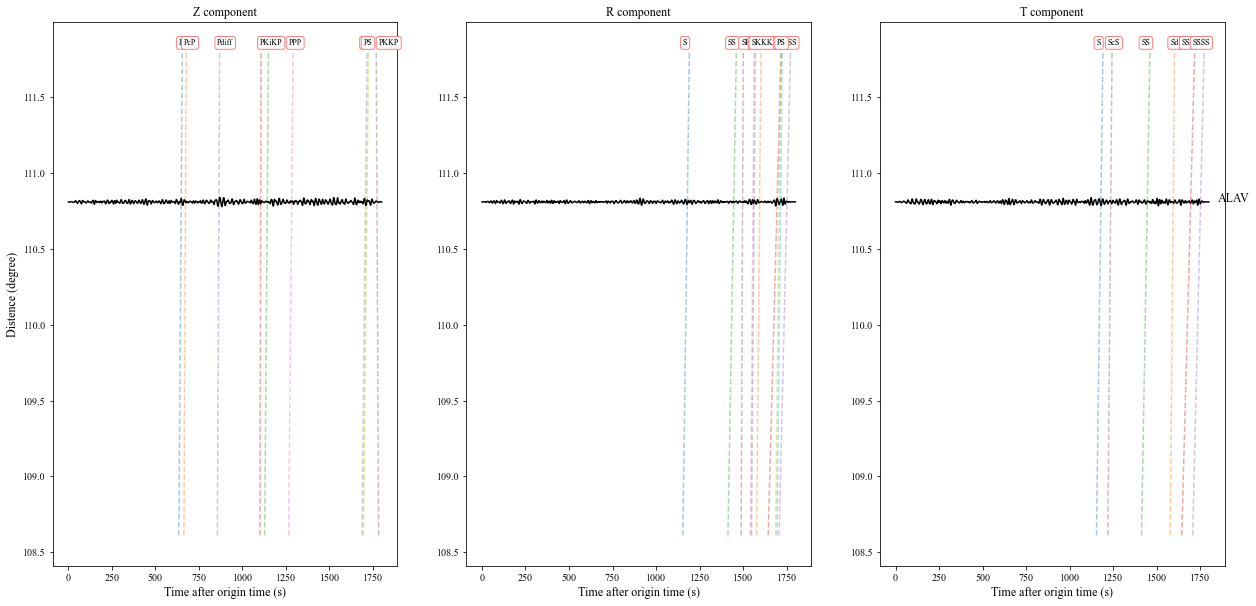

In [10]:
for i in range(502,510):
    cata = cat.iloc[i]
    eq_time = UTCDateTime(cata['Time'])
    print(eq_time)
    eq_lon  = cata['Lon']
    eq_lat  = cata['Lat']
    mag = cata['Mag']
    depth = cata['Depth']/1000
    
    yyyy = eq_time.year
    mm = checkday(eq_time.month)
    dd = checkday(eq_time.day)
    hh = checkday(eq_time.hour)
    minn = checkday(eq_time.minute)
    if int(yyyy) ==2014 : 
        deglist = [];STAlist=[]; BAZlist = []
        for net in network:
            NET_DIR = f'{DATA_DIR}{net}'
            NET_PZs = f'{PZ_DIR}/{net}'
            eq_DIR =  f'{NET_DIR}/{yyyy}{mm}{dd}{hh}{minn}'
            if net == 'AM' : color = 'k'
            elif net == 'TG' : color = 'slategrey'

            for path in sorted(glob.glob(f'{eq_DIR}/*Z')):

                STA = path.rsplit('.',2)[1]
                try: 
                    st_lat = (df['lat'][ (df['network'] == net ) & (df['station'] == STA) ]).item()
                    st_lon = (df['lon'][ (df['network'] == net ) & (df['station'] == STA) ]).item()

                    dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,st_lat,st_lon)
                    dist = dist/1000
                    deg = kilometer2degrees(dist)
                    STAlist.append(STA)
                    deglist.append(deg)
                    BAZlist.append(baz)
                except: print(f'{net} {STA} error') 
###===================add GNI=========================
        dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,40.15,44.74)
        dist = dist/1000
        deg = kilometer2degrees(dist)
        STAlist.append(STA)
        deglist.append(deg)
        BAZlist.append(baz)
##=============calculate traval time=====================
        min_arrivals = model.get_travel_times(source_depth_in_km=depth,distance_in_degree=min(deglist),phase_list=phaselist)
        for arr in min_arrivals:
            name=arr.phase.name
            if arr.time <1800:
                locals()['min_arr_%s' % (name)]= arr.time

        max_arrivals = model.get_travel_times(source_depth_in_km=depth,distance_in_degree=max(deglist),phase_list=phaselist)
        for arr in max_arrivals:
            name=arr.phase.name
            if arr.time <1800:       
                locals()['max_arr_%s' % (name)]= arr.time
##=============plot traval time curves=====================    
        plt.figure(1,figsize=(21,10))
        ax1 = plt.subplot(131)
        ax2 = plt.subplot(132)
        ax3 = plt.subplot(133)
        for phase in Zphase:
            try:
                min_arr_t= locals()['min_arr_%s' % (phase)]
                max_arr_t= locals()['max_arr_%s' % (phase)]
                if min_arr_t < 1800:
                    ax1.plot([min_arr_t,max_arr_t],[min(deglist)-0.1,max(deglist)+0.1],ls='--',alpha=0.4) 
                    ax1.text(min_arr_t,max(deglist)+0.15,phase,c='k',fontsize=8,ma='left',
                         bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc='white'))
            except KeyError: continue  
        for phase in Rphase:
            try:
                min_arr_t= locals()['min_arr_%s' % (phase)]
                max_arr_t= locals()['max_arr_%s' % (phase)]
                if min_arr_t < 1800:
                    ax2.plot([min_arr_t,max_arr_t],[min(deglist)-0.1,max(deglist)+0.1],ls='--',alpha=0.4) 
                    ax2.text(min_arr_t,max(deglist)+0.15,phase,c='k',fontsize=8,ma='left',
                         bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc='white'))
            except KeyError: continue
        for phase in Tphase:
            try:
                min_arr_t= locals()['min_arr_%s' % (phase)]
                max_arr_t= locals()['max_arr_%s' % (phase)]
                if min_arr_t < 1800:
                    ax3.plot([min_arr_t,max_arr_t],[min(deglist)-0.1,max(deglist)+0.1],ls='--',alpha=0.4) 
                    ax3.text(min_arr_t,max(deglist)+0.15,phase,c='k',fontsize=8,ma='left',
                         bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc='white'))
            except KeyError: continue
##=========================================================
        i=0
        for net in network:
            NET_DIR = f'{DATA_DIR}{net}'
            NET_PZs = f'{PZ_DIR}/{net}'
            eq_DIR =  f'{NET_DIR}/{yyyy}{mm}{dd}{hh}{minn}'
            if net == 'AM' : color = 'k'
            elif net == 'TG' : color = 'slategrey'

            for path in sorted(glob.glob(f'{eq_DIR}/*Z')):

                STA = path.rsplit('.',2)[1]
                if STA not in STAlist: continue
                deg = deglist[i]
                baz = BAZlist[i]
                print(net, STA)
                i+=1

                ori_st = Stream()
                for datapath in glob.glob(f'{eq_DIR}/*{STA}.HH?'):
                    channel = datapath.rsplit('.',1)[-1]
                    tr4pz = Trace()
                    PZs = glob.glob(f'{NET_PZs}/{STA}/*{STA}_{channel}.txt')
                    if PZs == [] and net == 'TG' :
                        PZs = glob.glob(f'{NET_PZs}/ABST/*ABST_{channel}.txt')
                    elif PZs == [] and net == 'AM':
                        PZs = glob.glob(f'{NET_PZs}/ARZA/*ARZA_{channel}.txt')
                    attach_paz(tr4pz,PZs[0])
                    paz = dict(tr4pz.stats.paz)
                    tr = read(datapath)
                    tr.simulate(paz_remove=paz,pre_filt=(0.033, 0.034, 45, 50))
                    ori_st += tr
                try:
                    st = ori_st.copy()
    #                     st.merge(fill_value=0)
                    st.detrend('linear')
                    st.detrend('demean')
                    st.taper(0.05,type='cosine')
                    st.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)

                    HHE = st.select(component='E')[0].data
                    HHN = st.select(component='N')[0].data
                    HHZ = st.select(component='Z')[0].data
                    HHR,HHT = rotate_ne_rt(HHN,HHE,baz)

                    times= st[0].times()
                    HHZ = HHZ / mmm
                    HHR = HHR / mmm
                    HHT = HHT / mmm

                    ax1.set_title('Z component',fontsize=12)
                    ax1.plot(times,HHZ*exg+deg,lw=1.5,color=color)
                    ax1.set_xlabel('Time after origin time (s)',fontsize=12)
                    ax1.set_ylabel('Distence (degree)',fontsize=12)
                    ax1.set_ylim(min(deglist)-0.3,max(deglist)+0.3)

                    ax2.set_title('R component',fontsize=12)
                    ax2.plot(times,HHR*exg+deg,lw=1.5,color=color)
                    ax2.set_xlabel('Time after origin time (s)',fontsize=12)
                    ax2.set_ylim(min(deglist)-0.3,max(deglist)+0.3)
                    if min(deglist) <=98: STAxloc = 1500
                    elif min(deglist) > 98: STAxloc = times[-1]
                    ax3.set_title('T component',fontsize=12)
                    ax3.plot(times,HHT*exg+deg,lw=1.5,color=color)
                    ax3.set_xlabel('Time after origin time (s)',fontsize=12)
                    ax3.set_ylim(min(deglist)-0.3,max(deglist)+0.3)
                    ax3.text(STAxloc+50,deg,STA,fontsize=12,color=color)
                except : print(f' {STA} error ')
######=============== for GNI ================
        try: 
            inv1 = client.get_stations(network="IU", station='GNI', channel="*",starttime=eq_time,endtime=eq_time+30*60)
            st_lat = inv1[0][0].latitude
            st_lon = inv1[0][0].longitude
            dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,st_lat,st_lon)
            dist = dist/1000
            deg = kilometer2degrees(dist)
            gni_st = client.get_waveforms('IU', "GNI",'00','*',eq_time,eq_time+30*60,attach_response=True)
            print('IU GNI')
            gni_st.remove_response(pre_filt = [0.001,0.005,9,10], output="DISP")
            gni_st.detrend('linear')
            gni_st.detrend('demean')
            gni_st.taper(0.05,type='cosine')
            gni_st.filter('bandpass',freqmin=0.04,freqmax=0.1,corners=4,zerophase=True)
            HH2 = gni_st.select(location='00', channel='BH2')[0].data
            HH1 = gni_st.select(location='00', channel='BH1')[0].data
            HHZ = gni_st.select(location='00', channel='BHZ')[0].data
            HHR,HHT = rotate_ne_rt(HH1,HH2,baz)
            times= gni_st[0].times()
            HHZ = HHZ / mmm
            HHR = HHR / mmm
            HHT = HHT / mmm
            ax1.plot(times,HHZ*exg+deg,lw=1.5,color='r')
            ax2.plot(times,HHR*exg+deg,lw=1.5,color='r')
            ax3.plot(times,HHT*exg+deg,lw=1.5,color='r')
            ax3.text(STAxloc+50,deg,'GNI',fontsize=12,color='r')
        except: print('GNI byebye QQ')                
        if min(deglist) <= 98 and 'min_arr_P' in locals():
            print('=============================align with P')
            ax1.text(min_arr_P,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
            ax2.text(min_arr_P,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
            ax3.text(min_arr_P,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
            ax1.set_xlim(min_arr_P-50,1500)#times[-1])
            ax2.set_xlim(min_arr_P-50,1500)#times[-1])
            ax3.set_xlim(min_arr_P-50,1500)#times[-1])
        elif min(deglist) > 98 and 'min_arr_Pdiff' in locals():
            print('=============================align with Pdiff')
            ax1.text(min_arr_Pdiff,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
            ax2.text(min_arr_Pdiff,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
            ax3.text(min_arr_Pdiff,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
            ax1.set_xlim(min_arr_Pdiff-50,times[-1])
            ax2.set_xlim(min_arr_Pdiff-50,times[-1])
            ax3.set_xlim(min_arr_Pdiff-50,times[-1])
        else : 
            ax1.text(950,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
            ax2.text(950,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
            ax3.text(950,max(deglist)+0.25,f'Amp: {mmm}',fontsize=8)
            ax1.set_xlim(950,times[-1])
            ax2.set_xlim(950,times[-1])
            ax3.set_xlim(950,times[-1])
        plt.suptitle(f'{eq_time}\n lat: {eq_lat} lon: {eq_lon} dep: {depth}km  Mag:{mag}\nbp: {freqmin}-{freqmax}Hz baz:{int(min(BAZlist))}', 
                     fontsize=20)
        plt.savefig(f'{FIG_DIR}/{eq_time}.png',dpi=200,facecolor='white')
        print('==========================figure save')
        plt.close()

#######==============變數刪除================    
        for arr in min_arrivals:
            name=arr.phase.name
            var = 'min_arr_'+name
            if var in locals():
                del locals()['min_arr_%s' % (name)]
        for arr in max_arrivals:
            name=arr.phase.name
            var = 'max_arr_'+name
            if var in locals():
                del locals()['max_arr_%s' % (name)]   